In [1]:
import json 
import networkx as nx
  

from conjecture.consolidated_functions import *
from conjecture.all_valid_orderings import *
from conjecture.optimization_functions import *
from iterative_heuristic.modified_etf import Mod_ETF
from iterative_heuristic.approximate_speeds import *
from makespan_energy.construct_graph_util import *
from makespan_energy.visualization_util import *
import networkx as nx
import numpy as np
import math
import plotly.express as px
import pandas as pd 

In [4]:
# Construct DAGs

file_list = ['epigenomics-chameleon-hep-1seq-50k-001.json',
'epigenomics-chameleon-hep-1seq-100k-001.json',
'epigenomics-chameleon-hep-2seq-50k-001.json',
'epigenomics-chameleon-hep-2seq-100k-001.json',
'epigenomics-chameleon-hep-3seq-50k-001.json',
'epigenomics-chameleon-hep-3seq-100k-001.json',
'epigenomics-chameleon-hep-4seq-50k-001.json',
'epigenomics-chameleon-hep-4seq-100k-001.json',
'epigenomics-chameleon-hep-5seq-50k-001.json',
'epigenomics-chameleon-hep-5seq-100k-001.json',
'epigenomics-chameleon-hep-6seq-50k-001.json',
'epigenomics-chameleon-hep-6seq-100k-001.json',
'epigenomics-chameleon-hep-7seq-50k-001.json',
'epigenomics-chameleon-hep-7seq-100k-001.json',
'epigenomics-chameleon-ilmn-1seq-50k-001.json',
'epigenomics-chameleon-ilmn-1seq-100k-001.json',
'epigenomics-chameleon-ilmn-2seq-50k-001.json',
'epigenomics-chameleon-ilmn-2seq-100k-001.json',
'epigenomics-chameleon-ilmn-3seq-50k-001.json',
'epigenomics-chameleon-ilmn-3seq-100k-001.json',
'epigenomics-chameleon-ilmn-4seq-50k-001.json',
'epigenomics-chameleon-ilmn-4seq-100k-001.json',
'epigenomics-chameleon-ilmn-5seq-50k-001.json',
'epigenomics-chameleon-ilmn-5seq-100k-001.json',
'epigenomics-chameleon-ilmn-6seq-50k-001.json',
'epigenomics-chameleon-ilmn-6seq-100k-001.json']
    
G_list = []

for file in file_list:
    
    # Opening JSON file 
    f = open('pegasus-traces-master/epigenomics/chameleon-cloud/' + file) 

    # returns JSON object as  
    # a dictionary 
    data = json.load(f) 

    taskname_to_id = {}
    id_count = 0

    G = nx.DiGraph()

    for task in data['workflow']['jobs']:

        child_id = id_count
        id_count += 1
        taskname_to_id[task['name']] = child_id

        if not G.has_node(child_id):
                G.add_node(child_id)

        for parent in task['parents']:
            if parent in taskname_to_id:

                parent_id = taskname_to_id[parent]

            else:

                parent_id = id_count
                id_count += 1
                taskname_to_id[parent] = parent_id


            if not G.has_edge(parent_id, child_id):
                    G.add_edge(parent_id, child_id)
    print(len(G.nodes))

    
   
    G_list.append(G)
    
    # Closing file 
    f.close() 

109
61
334
178
667
349
1006
520
1225
631
1474
760
1681
865
361
187
772
394
1189
607
1642
838
2095
1069
2542
1294


In [5]:
mrt = True
tie_breaking_rule = 2
plot = False

x = []
y = []
y_optimal = []
y_lb = []
bad_one = 0
box_whiskers_data = []
num_machines = 3

for G in G_list:
    
    
    ratio = []
    num_tasks = len(G.nodes)
    
    w = [1 for _ in range(num_tasks)]
    s = [1 for _ in range(num_tasks)]

    #d = get_optimal_schedule(mrt, G, num_machines, w, plot, verbose=False)

    test = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)

    # Initialize objective function value
    heuristic_opt = test.obj_value

    # Get pseudosize, convert to speed
    psize, group_interval = approx_psize_homogeneous(G, test.order, test.h, test.t, verbose=False)
    s_prime = psize_to_speed(psize)

    # Get ordering using modified ETF
    test2 = Mod_ETF(G, w, s_prime, num_machines, tie_breaking_rule, plot=False)

    # Check if the objective function value has improved
    if heuristic_opt > test2.obj_value:
        heuristic_opt = test2.obj_value
        s = s_prime

    _, _, obj_opt, _ = get_objective_single_ordering(True, G, w, test2.order, plot=plot, compare=False)

    # if solver was successful
    # and d["objective_task_scaling"] != 10000000
    if obj_opt != 10000000:
        
        x.append(num_tasks)
        y.append(heuristic_opt/obj_opt)
        
#         if d["objective_task_scaling"] > obj_opt:
#             bad_one += 1
#         counter += 1

#         box_whiskers_data.append([num_tasks, obj_opt/d["objective_task_scaling"]])
            
   

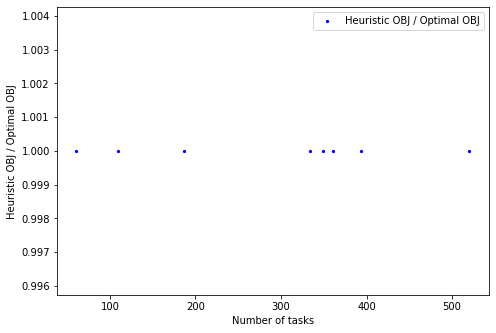

In [8]:
import matplotlib.pyplot as plt
import math

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])



#plt.scatter(obj_lb_lst[:,0], obj_lb_lst[:,1], label='lower bound', color="g", linewidths=0.1)


plt.scatter(x, y, s=5, label='Heuristic OBJ / Optimal OBJ', color='b')

plt.xlabel('Number of tasks')
plt.ylabel('Heuristic OBJ / Optimal OBJ')
plt.legend()
plt.show()